# Importing stuff

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from keras import losses
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from keras.models import Sequential
import numpy
from keras.layers import Dense, Flatten, Activation, Dropout
from keras.utils import normalize, to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os


print(tf.__version__)
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

Using TensorFlow backend.


2.0.0


# Setting up tensorboard

In [19]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [20]:
def get_run_logdir(): 
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S") 
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir() 
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

# Messing around with tfp stuff

In [5]:
n = tfd.Normal(loc=0., scale=1.)
n

<tfp.distributions.Normal 'Normal/' batch_shape=[] event_shape=[] dtype=float32>

In [6]:
n.sample().numpy()

-0.026782611

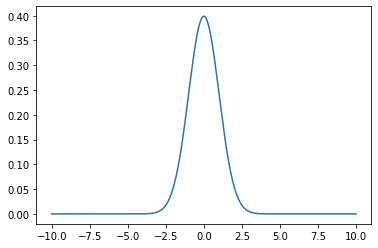

In [7]:
x=np.linspace(-10,10,1000)
y=np.exp(n.log_prob(x).numpy())
plt.plot(x,y)
plt.show()

In [8]:
b = tfd.Bernoulli(probs=0.7)
b

<tfp.distributions.Bernoulli 'Bernoulli/' batch_shape=[] event_shape=[] dtype=int32>

In [9]:
b.sample()

<tf.Tensor: id=58, shape=(), dtype=int32, numpy=1>

In [10]:
np.exp(b.log_prob(1).numpy())

0.7

In [11]:
nd = tfd.MultivariateNormalDiag(loc=[0., 10.], scale_diag=[1., 4.])
nd

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag/' batch_shape=[] event_shape=[2] dtype=float32>

In [12]:
nd.sample().numpy()

TypeError: Tensor is unhashable if Tensor equality is enabled. Instead, use tensor.experimental_ref() as the key.

# MPG example

Most of the code in the first part of this example comes from: https://www.tensorflow.org/tutorials/keras/basic_regression. I used the methods developed by googles tensorflow probability team and adapted some of their example code. The definitions of the priors and posteriors is not my own work. The gaussian process part is also largely copied from their example codes.

## Data download and preperation

Directly copied from the example code!

First we download and examine a standard dataset

In [13]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/Users/laurens/.keras/datasets/auto-mpg.data'

In [14]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [15]:
dataset = dataset.dropna()

In [16]:
origin = dataset.pop('Origin')

One hot encoding

In [17]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [18]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

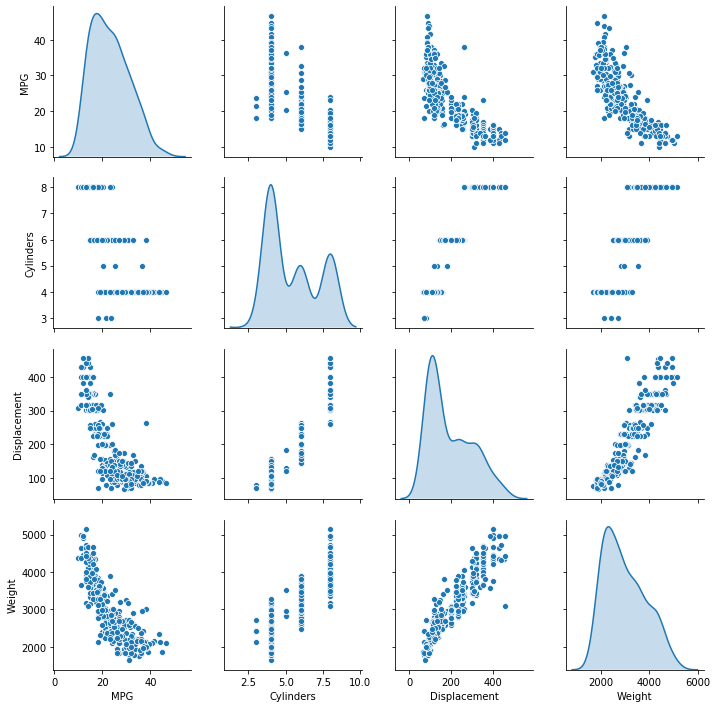

In [19]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")
plt.show()

In [20]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [21]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [22]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## Builing 4 models (probabilistic, dropout, and classical)

In [23]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [24]:
def build_model(): #probabilistic
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(2),
    tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss=negloglik,
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [25]:
def build_model2(): #classical, this is the model given in the original script
  model2 = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(2),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model2.compile(loss='mse',
                optimizer='adam',
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model2

In [26]:
model2 = build_model2()

In [27]:
model = build_model()

In [ ]:
model.fit(
  normed_train_data, train_labels,
  epochs=100, validation_split = 0.2, verbose=1)

Train on 251 samples, validate on 63 samples
Epoch 1/100


In [21]:
history=model2.fit(
  normed_train_data, train_labels,
  epochs=400, validation_split = 0.2, verbose=1, callbacks=[tensorboard_cb])

Train on 251 samples, validate on 63 samples
Epoch 1/400
251/251 [==============================] - 0s 871us/sample - loss: 548.5415 - mean_absolute_error: 22.1948 - mean_squared_error: 548.5415 - val_loss: 542.0012 - val_mean_absolute_error: 22.0418 - val_mean_squared_error: 542.0011
Epoch 2/400
251/251 [==============================] - 0s 74us/sample - loss: 503.4158 - mean_absolute_error: 21.2069 - mean_squared_error: 503.4158 - val_loss: 487.8756 - val_mean_absolute_error: 20.8355 - val_mean_squared_error: 487.8756
Epoch 3/400
251/251 [==============================] - 0s 64us/sample - loss: 450.5630 - mean_absolute_error: 19.9817 - mean_squared_error: 450.5630 - val_loss: 421.1383 - val_mean_absolute_error: 19.2455 - val_mean_squared_error: 421.1383
Epoch 4/400
251/251 [==============================] - 0s 69us/sample - loss: 383.4750 - mean_absolute_error: 18.3004 - mean_squared_error: 383.4750 - val_loss: 336.6750 - val_mean_absolute_error: 17.0270 - val_mean_squared_error: 336

Epoch 36/400
251/251 [==============================] - 0s 58us/sample - loss: 8.6235 - mean_absolute_error: 2.1652 - mean_squared_error: 8.6235 - val_loss: 9.4147 - val_mean_absolute_error: 2.3598 - val_mean_squared_error: 9.4147
Epoch 37/400
251/251 [==============================] - 0s 49us/sample - loss: 8.5173 - mean_absolute_error: 2.1563 - mean_squared_error: 8.5173 - val_loss: 9.1980 - val_mean_absolute_error: 2.3180 - val_mean_squared_error: 9.1980
Epoch 38/400
251/251 [==============================] - 0s 41us/sample - loss: 8.4230 - mean_absolute_error: 2.1358 - mean_squared_error: 8.4230 - val_loss: 9.1637 - val_mean_absolute_error: 2.3253 - val_mean_squared_error: 9.1637
Epoch 39/400
251/251 [==============================] - 0s 43us/sample - loss: 8.2975 - mean_absolute_error: 2.1044 - mean_squared_error: 8.2975 - val_loss: 9.2255 - val_mean_absolute_error: 2.3305 - val_mean_squared_error: 9.2255
Epoch 40/400
251/251 [==============================] - 0s 44us/sample - los

251/251 [==============================] - 0s 40us/sample - loss: 6.0167 - mean_absolute_error: 1.7184 - mean_squared_error: 6.0167 - val_loss: 8.6488 - val_mean_absolute_error: 2.2000 - val_mean_squared_error: 8.6488
Epoch 107/400
251/251 [==============================] - 0s 45us/sample - loss: 6.0570 - mean_absolute_error: 1.7577 - mean_squared_error: 6.0570 - val_loss: 8.5381 - val_mean_absolute_error: 2.1702 - val_mean_squared_error: 8.5381
Epoch 108/400
251/251 [==============================] - 0s 50us/sample - loss: 5.9530 - mean_absolute_error: 1.7340 - mean_squared_error: 5.9530 - val_loss: 8.5747 - val_mean_absolute_error: 2.2086 - val_mean_squared_error: 8.5747
Epoch 109/400
251/251 [==============================] - 0s 45us/sample - loss: 6.0285 - mean_absolute_error: 1.7205 - mean_squared_error: 6.0285 - val_loss: 8.6212 - val_mean_absolute_error: 2.2363 - val_mean_squared_error: 8.6212
Epoch 110/400
251/251 [==============================] - 0s 39us/sample - loss: 6.0083

251/251 [==============================] - 0s 44us/sample - loss: 5.3210 - mean_absolute_error: 1.5981 - mean_squared_error: 5.3210 - val_loss: 8.5758 - val_mean_absolute_error: 2.2535 - val_mean_squared_error: 8.5758
Epoch 177/400
251/251 [==============================] - 0s 43us/sample - loss: 5.3322 - mean_absolute_error: 1.5819 - mean_squared_error: 5.3322 - val_loss: 8.2775 - val_mean_absolute_error: 2.1798 - val_mean_squared_error: 8.2775
Epoch 178/400
251/251 [==============================] - 0s 45us/sample - loss: 5.4081 - mean_absolute_error: 1.6280 - mean_squared_error: 5.4081 - val_loss: 8.3423 - val_mean_absolute_error: 2.1570 - val_mean_squared_error: 8.3423
Epoch 179/400
251/251 [==============================] - 0s 43us/sample - loss: 5.5167 - mean_absolute_error: 1.6077 - mean_squared_error: 5.5167 - val_loss: 8.4242 - val_mean_absolute_error: 2.2273 - val_mean_squared_error: 8.4242
Epoch 180/400
251/251 [==============================] - 0s 44us/sample - loss: 5.4193

251/251 [==============================] - 0s 41us/sample - loss: 4.9471 - mean_absolute_error: 1.5167 - mean_squared_error: 4.9471 - val_loss: 8.2095 - val_mean_absolute_error: 2.1550 - val_mean_squared_error: 8.2095
Epoch 247/400
251/251 [==============================] - 0s 39us/sample - loss: 4.9452 - mean_absolute_error: 1.5199 - mean_squared_error: 4.9452 - val_loss: 8.2574 - val_mean_absolute_error: 2.1733 - val_mean_squared_error: 8.2574
Epoch 248/400
251/251 [==============================] - 0s 42us/sample - loss: 4.9263 - mean_absolute_error: 1.5038 - mean_squared_error: 4.9263 - val_loss: 8.3305 - val_mean_absolute_error: 2.1904 - val_mean_squared_error: 8.3305
Epoch 249/400
251/251 [==============================] - 0s 42us/sample - loss: 4.9735 - mean_absolute_error: 1.5319 - mean_squared_error: 4.9735 - val_loss: 8.2449 - val_mean_absolute_error: 2.1586 - val_mean_squared_error: 8.2449
Epoch 250/400
251/251 [==============================] - 0s 41us/sample - loss: 4.9412

251/251 [==============================] - 0s 39us/sample - loss: 4.6294 - mean_absolute_error: 1.4749 - mean_squared_error: 4.6294 - val_loss: 8.4442 - val_mean_absolute_error: 2.2088 - val_mean_squared_error: 8.4442
Epoch 317/400
251/251 [==============================] - 0s 47us/sample - loss: 4.8812 - mean_absolute_error: 1.4500 - mean_squared_error: 4.8812 - val_loss: 8.5975 - val_mean_absolute_error: 2.2374 - val_mean_squared_error: 8.5975
Epoch 318/400
251/251 [==============================] - 0s 48us/sample - loss: 4.4990 - mean_absolute_error: 1.4660 - mean_squared_error: 4.4990 - val_loss: 8.6145 - val_mean_absolute_error: 2.1859 - val_mean_squared_error: 8.6145
Epoch 319/400
251/251 [==============================] - 0s 46us/sample - loss: 4.6658 - mean_absolute_error: 1.4847 - mean_squared_error: 4.6658 - val_loss: 8.4968 - val_mean_absolute_error: 2.2405 - val_mean_squared_error: 8.4968
Epoch 320/400
251/251 [==============================] - 0s 39us/sample - loss: 4.5659

251/251 [==============================] - 0s 41us/sample - loss: 4.5930 - mean_absolute_error: 1.4216 - mean_squared_error: 4.5930 - val_loss: 8.7677 - val_mean_absolute_error: 2.2570 - val_mean_squared_error: 8.7677
Epoch 387/400
251/251 [==============================] - 0s 47us/sample - loss: 4.4034 - mean_absolute_error: 1.4540 - mean_squared_error: 4.4034 - val_loss: 8.7852 - val_mean_absolute_error: 2.2270 - val_mean_squared_error: 8.7852
Epoch 388/400
251/251 [==============================] - 0s 50us/sample - loss: 3.9593 - mean_absolute_error: 1.3443 - mean_squared_error: 3.9593 - val_loss: 8.8127 - val_mean_absolute_error: 2.2605 - val_mean_squared_error: 8.8127
Epoch 389/400
251/251 [==============================] - 0s 40us/sample - loss: 4.1527 - mean_absolute_error: 1.3349 - mean_squared_error: 4.1527 - val_loss: 8.6685 - val_mean_absolute_error: 2.2228 - val_mean_squared_error: 8.6685
Epoch 390/400
251/251 [==============================] - 0s 37us/sample - loss: 4.0860

In [472]:
# Load TENSORBOARD
%load_ext tensorboard
# Start TENSORBOARD
%tensorboard --logdir my_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6009 (pid 31971), started 0:02:23 ago. (Use '!kill 31971' to kill it.)

In [22]:
model.save("model.h5")
model2.save('model2.h5')

## Dropout

In [23]:
ELU=tf.keras.layers.ELU(alpha=1.0)
inputs = tf.keras.Input(shape=len(train_dataset.keys()))
d0=layers.Dropout(0.1)(inputs,training=True)
c1= layers.Dense(64)(d0)
d1=layers.Dropout(0.5)(c1,training=True)
a1=tf.keras.layers.ELU(alpha=1.0)(d1)
c2=layers.Dense(2)(a1)
#d2=layers.Dropout(0.00)(c2,training=True)
#a2=tf.keras.layers.ELU(alpha=1.0)(d2)
c3=layers.Dense(1)(c2)
#outputs=layers.Activation('softmax')(c2)
model_dropout = tf.keras.Model(inputs, c3)
model_dropout.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dropout (Dropout)            (None, 9)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                640       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
elu_1 (ELU)                  (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 130       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 3     

In [24]:
model_dropout.compile(
    loss='mse',
    optimizer='adam',
    metrics=['accuracy']
)

In [25]:
history_dropout = model_dropout.fit(
    normed_train_data, train_labels,
    epochs=500,
    validation_split=0.2,
    verbose = 1,
)

Train on 251 samples, validate on 63 samples
Epoch 1/500
251/251 [==============================] - 0s 854us/sample - loss: 603.0176 - accuracy: 0.0000e+00 - val_loss: 616.3539 - val_accuracy: 0.0000e+00
Epoch 2/500
251/251 [==============================] - 0s 58us/sample - loss: 588.9214 - accuracy: 0.0000e+00 - val_loss: 595.7719 - val_accuracy: 0.0000e+00
Epoch 3/500
251/251 [==============================] - 0s 57us/sample - loss: 565.2058 - accuracy: 0.0000e+00 - val_loss: 579.6893 - val_accuracy: 0.0000e+00
Epoch 4/500
251/251 [==============================] - 0s 71us/sample - loss: 551.9305 - accuracy: 0.0000e+00 - val_loss: 554.1419 - val_accuracy: 0.0000e+00
Epoch 5/500
251/251 [==============================] - 0s 74us/sample - loss: 533.5253 - accuracy: 0.0000e+00 - val_loss: 550.3639 - val_accuracy: 0.0000e+00
Epoch 6/500
251/251 [==============================] - 0s 53us/sample - loss: 528.7013 - accuracy: 0.0000e+00 - val_loss: 517.5444 - val_accuracy: 0.0000e+00
Epoch 

251/251 [==============================] - 0s 36us/sample - loss: 26.9422 - accuracy: 0.0000e+00 - val_loss: 29.7432 - val_accuracy: 0.0000e+00
Epoch 105/500
251/251 [==============================] - 0s 38us/sample - loss: 30.2547 - accuracy: 0.0000e+00 - val_loss: 31.4638 - val_accuracy: 0.0000e+00
Epoch 106/500
251/251 [==============================] - 0s 36us/sample - loss: 28.5923 - accuracy: 0.0000e+00 - val_loss: 29.6004 - val_accuracy: 0.0000e+00
Epoch 107/500
251/251 [==============================] - 0s 35us/sample - loss: 28.1567 - accuracy: 0.0000e+00 - val_loss: 37.6082 - val_accuracy: 0.0000e+00
Epoch 108/500
251/251 [==============================] - 0s 36us/sample - loss: 27.1542 - accuracy: 0.0000e+00 - val_loss: 30.8276 - val_accuracy: 0.0000e+00
Epoch 109/500
251/251 [==============================] - 0s 42us/sample - loss: 22.6076 - accuracy: 0.0000e+00 - val_loss: 23.3600 - val_accuracy: 0.0000e+00
Epoch 110/500
251/251 [==============================] - 0s 35us/s

Epoch 156/500
251/251 [==============================] - 0s 36us/sample - loss: 28.7780 - accuracy: 0.0000e+00 - val_loss: 23.0037 - val_accuracy: 0.0000e+00
Epoch 157/500
251/251 [==============================] - 0s 34us/sample - loss: 22.0748 - accuracy: 0.0000e+00 - val_loss: 30.6977 - val_accuracy: 0.0000e+00
Epoch 158/500
251/251 [==============================] - 0s 32us/sample - loss: 23.7459 - accuracy: 0.0000e+00 - val_loss: 23.3402 - val_accuracy: 0.0000e+00
Epoch 159/500
251/251 [==============================] - 0s 37us/sample - loss: 27.0034 - accuracy: 0.0000e+00 - val_loss: 30.4062 - val_accuracy: 0.0000e+00
Epoch 160/500
251/251 [==============================] - 0s 32us/sample - loss: 24.6388 - accuracy: 0.0000e+00 - val_loss: 23.3439 - val_accuracy: 0.0000e+00
Epoch 161/500
251/251 [==============================] - 0s 36us/sample - loss: 23.5183 - accuracy: 0.0000e+00 - val_loss: 27.0836 - val_accuracy: 0.0000e+00
Epoch 162/500
251/251 [=============================

Epoch 208/500
251/251 [==============================] - 0s 38us/sample - loss: 21.0888 - accuracy: 0.0000e+00 - val_loss: 21.7518 - val_accuracy: 0.0000e+00
Epoch 209/500
251/251 [==============================] - 0s 36us/sample - loss: 23.3195 - accuracy: 0.0000e+00 - val_loss: 27.1977 - val_accuracy: 0.0000e+00
Epoch 210/500
251/251 [==============================] - 0s 35us/sample - loss: 19.2892 - accuracy: 0.0000e+00 - val_loss: 24.6704 - val_accuracy: 0.0000e+00
Epoch 211/500
251/251 [==============================] - 0s 38us/sample - loss: 23.4944 - accuracy: 0.0000e+00 - val_loss: 24.3305 - val_accuracy: 0.0000e+00
Epoch 212/500
251/251 [==============================] - 0s 33us/sample - loss: 23.1655 - accuracy: 0.0000e+00 - val_loss: 31.9343 - val_accuracy: 0.0000e+00
Epoch 213/500
251/251 [==============================] - 0s 37us/sample - loss: 23.5055 - accuracy: 0.0000e+00 - val_loss: 31.0205 - val_accuracy: 0.0000e+00
Epoch 214/500
251/251 [=============================

Epoch 260/500
251/251 [==============================] - 0s 38us/sample - loss: 20.4527 - accuracy: 0.0000e+00 - val_loss: 20.7715 - val_accuracy: 0.0000e+00
Epoch 261/500
251/251 [==============================] - 0s 35us/sample - loss: 20.5025 - accuracy: 0.0000e+00 - val_loss: 22.9113 - val_accuracy: 0.0000e+00
Epoch 262/500
251/251 [==============================] - 0s 36us/sample - loss: 22.6147 - accuracy: 0.0000e+00 - val_loss: 19.8620 - val_accuracy: 0.0000e+00
Epoch 263/500
251/251 [==============================] - 0s 33us/sample - loss: 16.7639 - accuracy: 0.0000e+00 - val_loss: 17.2647 - val_accuracy: 0.0000e+00
Epoch 264/500
251/251 [==============================] - 0s 35us/sample - loss: 21.5973 - accuracy: 0.0000e+00 - val_loss: 17.7349 - val_accuracy: 0.0000e+00
Epoch 265/500
251/251 [==============================] - 0s 37us/sample - loss: 21.6432 - accuracy: 0.0000e+00 - val_loss: 23.0294 - val_accuracy: 0.0000e+00
Epoch 266/500
251/251 [=============================

Epoch 312/500
251/251 [==============================] - 0s 40us/sample - loss: 20.8193 - accuracy: 0.0000e+00 - val_loss: 29.6803 - val_accuracy: 0.0000e+00
Epoch 313/500
251/251 [==============================] - 0s 41us/sample - loss: 18.6268 - accuracy: 0.0000e+00 - val_loss: 17.5348 - val_accuracy: 0.0000e+00
Epoch 314/500
251/251 [==============================] - 0s 42us/sample - loss: 19.1967 - accuracy: 0.0000e+00 - val_loss: 18.9268 - val_accuracy: 0.0000e+00
Epoch 315/500
251/251 [==============================] - 0s 36us/sample - loss: 26.8336 - accuracy: 0.0000e+00 - val_loss: 21.3053 - val_accuracy: 0.0000e+00
Epoch 316/500
251/251 [==============================] - 0s 39us/sample - loss: 22.6408 - accuracy: 0.0000e+00 - val_loss: 20.8342 - val_accuracy: 0.0000e+00
Epoch 317/500
251/251 [==============================] - 0s 41us/sample - loss: 20.7104 - accuracy: 0.0000e+00 - val_loss: 20.9381 - val_accuracy: 0.0000e+00
Epoch 318/500
251/251 [=============================

Epoch 364/500
251/251 [==============================] - 0s 36us/sample - loss: 18.6280 - accuracy: 0.0000e+00 - val_loss: 20.4728 - val_accuracy: 0.0000e+00
Epoch 365/500
251/251 [==============================] - 0s 42us/sample - loss: 20.6701 - accuracy: 0.0000e+00 - val_loss: 17.8915 - val_accuracy: 0.0000e+00
Epoch 366/500
251/251 [==============================] - 0s 35us/sample - loss: 22.8590 - accuracy: 0.0000e+00 - val_loss: 27.4990 - val_accuracy: 0.0000e+00
Epoch 367/500
251/251 [==============================] - 0s 38us/sample - loss: 19.3705 - accuracy: 0.0000e+00 - val_loss: 21.2589 - val_accuracy: 0.0000e+00
Epoch 368/500
251/251 [==============================] - 0s 36us/sample - loss: 19.5461 - accuracy: 0.0000e+00 - val_loss: 13.9950 - val_accuracy: 0.0000e+00
Epoch 369/500
251/251 [==============================] - 0s 34us/sample - loss: 23.0879 - accuracy: 0.0000e+00 - val_loss: 13.0425 - val_accuracy: 0.0000e+00
Epoch 370/500
251/251 [=============================

Epoch 416/500
251/251 [==============================] - 0s 42us/sample - loss: 21.5980 - accuracy: 0.0000e+00 - val_loss: 19.2632 - val_accuracy: 0.0000e+00
Epoch 417/500
251/251 [==============================] - 0s 38us/sample - loss: 18.7231 - accuracy: 0.0000e+00 - val_loss: 21.4731 - val_accuracy: 0.0000e+00
Epoch 418/500
251/251 [==============================] - 0s 33us/sample - loss: 20.1707 - accuracy: 0.0000e+00 - val_loss: 21.0451 - val_accuracy: 0.0000e+00
Epoch 419/500
251/251 [==============================] - 0s 38us/sample - loss: 20.5952 - accuracy: 0.0000e+00 - val_loss: 20.4137 - val_accuracy: 0.0000e+00
Epoch 420/500
251/251 [==============================] - 0s 34us/sample - loss: 21.2112 - accuracy: 0.0000e+00 - val_loss: 20.6511 - val_accuracy: 0.0000e+00
Epoch 421/500
251/251 [==============================] - 0s 37us/sample - loss: 22.7999 - accuracy: 0.0000e+00 - val_loss: 18.9837 - val_accuracy: 0.0000e+00
Epoch 422/500
251/251 [=============================

Epoch 468/500
251/251 [==============================] - 0s 38us/sample - loss: 19.7554 - accuracy: 0.0000e+00 - val_loss: 17.1738 - val_accuracy: 0.0000e+00
Epoch 469/500
251/251 [==============================] - 0s 39us/sample - loss: 21.3976 - accuracy: 0.0000e+00 - val_loss: 19.0998 - val_accuracy: 0.0000e+00
Epoch 470/500
251/251 [==============================] - 0s 34us/sample - loss: 19.4583 - accuracy: 0.0000e+00 - val_loss: 17.1916 - val_accuracy: 0.0000e+00
Epoch 471/500
251/251 [==============================] - 0s 37us/sample - loss: 20.3723 - accuracy: 0.0000e+00 - val_loss: 17.8487 - val_accuracy: 0.0000e+00
Epoch 472/500
251/251 [==============================] - 0s 36us/sample - loss: 17.8865 - accuracy: 0.0000e+00 - val_loss: 17.6137 - val_accuracy: 0.0000e+00
Epoch 473/500
251/251 [==============================] - 0s 40us/sample - loss: 17.4441 - accuracy: 0.0000e+00 - val_loss: 22.7277 - val_accuracy: 0.0000e+00
Epoch 474/500
251/251 [=============================

In [26]:
model_dropout.save("model_dropout.h5")

In [27]:
class RBFKernelFn(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(RBFKernelFn, self).__init__(**kwargs)
    dtype = kwargs.get('dtype', None)

    self._amplitude = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='amplitude')
    
    self._length_scale = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='length_scale')

  def call(self, x):
    # Never called -- this is just a layer so it can hold variables
    # in a way Keras understands.
    return x

  @property
  def kernel(self):
    return tfp.positive_semidefinite_kernels.ExponentiatedQuadratic(
      amplitude=tf.nn.softplus(0.1 * self._amplitude),
      length_scale=tf.nn.softplus(5. * self._length_scale)
    )

In [28]:
num_inducing_points = 100
model4 = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(2),
    layers.Dense(1),
    tfp.layers.VariationalGaussianProcess(
        num_inducing_points=num_inducing_points,
        kernel_provider=RBFKernelFn(),
        event_shape=[1],
        inducing_index_points_initializer=tf.constant_initializer(
            np.linspace(*[-1,1], num=num_inducing_points)[..., np.newaxis]),
        unconstrained_observation_noise_variance_initializer=(
            tf.constant_initializer(np.array(0.54)))),
  ])

In [29]:
loss = lambda y, rv_y: rv_y.variational_loss(
    y, kl_weight=np.array(10, x.dtype) / 50)
model4.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss=loss)
model4.summary()

NameError: name 'x' is not defined

In [417]:
model4.fit(normed_train_data.to_numpy(), train_labels, batch_size=10, epochs=50, verbose=True)

Train on 314 samples
Epoch 1/50
314/314 [==============================] - 1s 3ms/sample - loss: 2692.0180
Epoch 2/50
314/314 [==============================] - 0s 268us/sample - loss: 2613.9858
Epoch 3/50
314/314 [==============================] - 0s 239us/sample - loss: 2559.2309
Epoch 4/50
314/314 [==============================] - 0s 216us/sample - loss: 2495.5114
Epoch 5/50
314/314 [==============================] - 0s 212us/sample - loss: 2448.1461
Epoch 6/50
314/314 [==============================] - 0s 211us/sample - loss: 2393.6799
Epoch 7/50
314/314 [==============================] - 0s 213us/sample - loss: 2328.5791
Epoch 8/50
314/314 [==============================] - 0s 209us/sample - loss: 2271.9944
Epoch 9/50
314/314 [==============================] - 0s 215us/sample - loss: 2237.8525
Epoch 10/50
314/314 [==============================] - 0s 216us/sample - loss: 2186.9750
Epoch 11/50
314/314 [==============================] - 0s 233us/sample - loss: 2122.0425
Epoch 12/50

## Comparing the results

In [65]:
tn=40

In [66]:
example_batch = normed_test_data[:tn]

In [ ]:
me=model(example_batch.to_numpy()).mean().numpy()
std=model(example_batch.to_numpy()).stddev().numpy()

In [473]:
me2=model4(example_batch.to_numpy()).mean()

In [493]:
vrb=[]
for i in range(0,200):
    l=model4(np.asmatrix(example_batch.to_numpy()[1])).sample().numpy().tolist()[0][0]
    vrb.append(l)

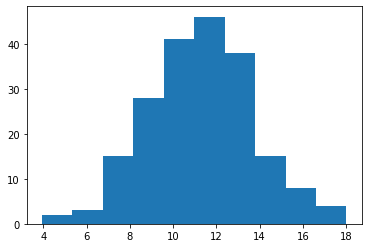

In [495]:
plt.hist(vrb)
plt.show()

In [426]:
std2=model4(example_batch.to_numpy())
std2

<tfp.distributions.TransformedDistribution 'transposeIndependentsequential_30/variational_gaussian_process_22/VariataionalGaussianProcess/' batch_shape=[] event_shape=[40, 1] dtype=float32>

In [428]:
def gauspred(x):
    B=100
    d=[]
    a=model4(x).sample()
    for i in range(1,B):
        l=model4(x).sample()
        a=np.hstack((a,l))
    return(a)

In [430]:
gp=gauspred(example_batch.to_numpy())

In [288]:
def droppredict(x):
    B=100
    d=[]
    a=model_dropout.predict(x)
    for i in range(1,B):
        l=model_dropout.predict(x)
        a=np.hstack((a,l))
    return(a)

In [315]:
md=droppredict(example_batch)

In [431]:
df = pd.DataFrame(data=np.column_stack((me,std,md.mean(axis=1),np.sqrt(md.var(axis=1)),gp.mean(axis=1),np.sqrt(gp.var(axis=1))
                                        ,model2.predict(example_batch),test_labels[:tn])),
                  columns=['tfp mean','tfp std','dropout mean','dropout stdev','Gaus Mean','Gaus std','classic','true'])
df

,tfp mean,tfp std,dropout mean,dropout stdev,Gaus Mean,Gaus std,classic,true
0,16.615889,1.211003,14.346698,2.551111,15.104478,2.999994,16.782129,15.0
1,11.190832,0.967606,10.723137,2.257241,11.668277,2.257604,11.244649,10.0
2,11.999650,1.035679,9.619412,2.634160,8.760547,1.765841,12.211715,9.0
3,24.240805,2.469728,23.231640,3.791487,25.854607,4.843260,23.046797,25.0
4,21.633820,1.664374,19.912867,2.584640,20.844883,3.934191,22.428860,19.0
5,13.381469,1.079394,12.989202,2.099322,14.118375,2.699134,13.210623,14.0
6,13.612966,1.111978,13.582804,2.282643,14.069480,2.752482,12.993000,14.0
7,13.175472,1.070575,12.333518,2.446663,13.379936,2.665951,12.950930,13.0
8,20.181692,1.575255,17.736345,2.834049,19.511934,3.619054,20.369175,18.0
9,29.840733,3.046373,28.371742,4.078119,31.548779,5.874182,29.525169,35.0


## Combining aleatoric and epistemic uncertainty

The approach is as follows: to deal with aleatoric uncertainty I output the mean and variance of a normal distribution and I use the negative log likelihood as the loss function. In order to deal with epistemic uncertainty I let the network learn a distribution over the weights instead of point estimates. This means that everytime I put some datapoint through my trained network it will output a different (!) distribution. I can then do this a number of times and look at the mean of means of the distributions. I can also look at the variance of the means of distributions. This will tell me how certain my model is of the mean (epistemic uncertainty in this case). I can also look at the mean of the variances of the distribution (this tells me how certain my model is about the aleatoric uncertainty).

### Posteriors and prios

In [30]:
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

def posterior_mean_field2(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

def posterior_mean_field3(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

In [31]:
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

def prior_trainable2(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

def prior_trainable3(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

### Model 5 (epistemic and aleatoric)

In [32]:
model5 = tf.keras.Sequential([
  tfp.layers.DenseVariational(10, posterior_mean_field, prior_trainable, kl_weight=1/normed_train_data.shape[0],input_shape=[len(train_dataset.keys())]),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05*t[...,1:]))),
])



In [37]:
model5.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)

In [38]:
model5.fit(normed_train_data, train_labels, batch_size=50, epochs=800, verbose=True)

Train on 314 samples
Epoch 1/800
314/314 [==============================] - 0s 554us/sample - loss: 5.4495
Epoch 2/800
314/314 [==============================] - 0s 27us/sample - loss: 5.2964
Epoch 3/800
314/314 [==============================] - 0s 23us/sample - loss: 5.2340
Epoch 4/800
314/314 [==============================] - 0s 39us/sample - loss: 5.2027
Epoch 5/800
314/314 [==============================] - 0s 30us/sample - loss: 5.1728
Epoch 6/800
314/314 [==============================] - 0s 27us/sample - loss: 5.1089
Epoch 7/800
314/314 [==============================] - 0s 26us/sample - loss: 5.0818
Epoch 8/800
314/314 [==============================] - 0s 26us/sample - loss: 5.0600
Epoch 9/800
314/314 [==============================] - 0s 23us/sample - loss: 5.0528
Epoch 10/800
314/314 [==============================] - 0s 25us/sample - loss: 4.9261
Epoch 11/800
314/314 [==============================] - 0s 21us/sample - loss: 4.9739
Epoch 12/800
314/314 [===================

314/314 [==============================] - 0s 24us/sample - loss: 3.9591
Epoch 97/800
314/314 [==============================] - 0s 22us/sample - loss: 3.9491
Epoch 98/800
314/314 [==============================] - 0s 23us/sample - loss: 3.9362
Epoch 99/800
314/314 [==============================] - 0s 17us/sample - loss: 3.9316
Epoch 100/800
314/314 [==============================] - 0s 21us/sample - loss: 3.8974
Epoch 101/800
314/314 [==============================] - 0s 18us/sample - loss: 3.9385
Epoch 102/800
314/314 [==============================] - 0s 21us/sample - loss: 3.8926
Epoch 103/800
314/314 [==============================] - 0s 20us/sample - loss: 3.8707
Epoch 104/800
314/314 [==============================] - 0s 19us/sample - loss: 3.8850
Epoch 105/800
314/314 [==============================] - 0s 20us/sample - loss: 3.8403
Epoch 106/800
314/314 [==============================] - 0s 20us/sample - loss: 3.8570
Epoch 107/800
314/314 [==============================] - 0s 

314/314 [==============================] - 0s 20us/sample - loss: 3.1960
Epoch 285/800
314/314 [==============================] - 0s 23us/sample - loss: 3.2463
Epoch 286/800
314/314 [==============================] - 0s 22us/sample - loss: 3.1941
Epoch 287/800
314/314 [==============================] - 0s 20us/sample - loss: 3.2322
Epoch 288/800
314/314 [==============================] - 0s 22us/sample - loss: 3.2024
Epoch 289/800
314/314 [==============================] - 0s 17us/sample - loss: 3.2128
Epoch 290/800
314/314 [==============================] - 0s 24us/sample - loss: 3.2519
Epoch 291/800
314/314 [==============================] - 0s 19us/sample - loss: 3.2119
Epoch 292/800
314/314 [==============================] - 0s 21us/sample - loss: 3.2192
Epoch 293/800
314/314 [==============================] - 0s 19us/sample - loss: 3.1970
Epoch 294/800
314/314 [==============================] - 0s 19us/sample - loss: 3.1778
Epoch 295/800
314/314 [==============================] - 

314/314 [==============================] - 0s 21us/sample - loss: 2.9278
Epoch 473/800
314/314 [==============================] - 0s 20us/sample - loss: 2.9427
Epoch 474/800
314/314 [==============================] - 0s 21us/sample - loss: 2.9341
Epoch 475/800
314/314 [==============================] - 0s 26us/sample - loss: 2.9331
Epoch 476/800
314/314 [==============================] - 0s 20us/sample - loss: 2.9187
Epoch 477/800
314/314 [==============================] - 0s 21us/sample - loss: 2.9078
Epoch 478/800
314/314 [==============================] - 0s 19us/sample - loss: 2.9214
Epoch 479/800
314/314 [==============================] - 0s 26us/sample - loss: 2.9049
Epoch 480/800
314/314 [==============================] - 0s 20us/sample - loss: 2.9410
Epoch 481/800
314/314 [==============================] - 0s 26us/sample - loss: 2.9020
Epoch 482/800
314/314 [==============================] - 0s 20us/sample - loss: 2.8839
Epoch 483/800
314/314 [==============================] - 

314/314 [==============================] - 0s 23us/sample - loss: 2.7698
Epoch 661/800
314/314 [==============================] - 0s 21us/sample - loss: 2.7816
Epoch 662/800
314/314 [==============================] - 0s 23us/sample - loss: 2.7870
Epoch 663/800
314/314 [==============================] - 0s 23us/sample - loss: 2.7966
Epoch 664/800
314/314 [==============================] - 0s 21us/sample - loss: 2.7726
Epoch 665/800
314/314 [==============================] - 0s 23us/sample - loss: 2.8009
Epoch 666/800
314/314 [==============================] - 0s 22us/sample - loss: 2.7853
Epoch 667/800
314/314 [==============================] - 0s 23us/sample - loss: 2.7765
Epoch 668/800
314/314 [==============================] - 0s 19us/sample - loss: 2.7638
Epoch 669/800
314/314 [==============================] - 0s 24us/sample - loss: 2.7736
Epoch 670/800
314/314 [==============================] - 0s 18us/sample - loss: 2.7870
Epoch 671/800
314/314 [==============================] - 

In [44]:
model5.save("model5.h5")

RuntimeError: Unable to create link (name already exists)

#### Getting the mean and variance of means and variances

In [45]:
model5 = keras.models.load_model("model5.h5")

ValueError: Unknown layer: DenseVariational

In [151]:
def epi(x):
    B1=4
    B=4
    de=model5(x)
    d=de.sample()
    for i in range(1,B):
            l=model5(x).sample()
            d=np.hstack((d,l))      
    return(e)

In [152]:
def epi2(x):
    B1=100 #The number of distributions I evaluate 
    B2=100 #The number of points I take from a distribution to determine the variance
    de=model5(x)
    d=de.sample()
    for i in range(1,B2):
        l=de.sample()
        d=np.hstack((d,l))
    e=np.var(d,axis=1)
    for b in range(0,B1):
        de=model5(x)
        d=de.sample()
        for c in range(1,B2):
            l=de.sample()
            d=np.hstack((d,l))
        t=np.var(d,axis=1)
        e=np.hstack((e,t))
    final=e.reshape(len(x),np.int(len(e)/len(x)))
    return(final)

In [153]:
def meane(x):
    B=100
    d=[]
    a=model5(x).mean()
    for i in range(1,B):
        l=model5(x).mean()
        a=np.hstack((a,l))
    return(a)

In [171]:
epis=epi2(example_batch.to_numpy())

In [172]:
means=meane(example_batch.to_numpy())

### Results

I have trained a neural network that outputs a distribution. This distribution has a mean and a variance. Since the weights are not a point estimate but a distribution, I get a different distribution every time I put data trough the network! I did this a number of times in order to get the average of the means of the distribution and the variance of the variances of the distributions. This second quantity can be thought of as the model uncertainty of the aleatoric uncertainty! The first column gives the mean (over all the distribution realisations) of the mean of the distributions. The second column gives the variance of the means (how much do the means change if we pass the same point through the network a number of times?). The third column is the mean of the variances of the distributions. I calculated this by taking B1 different distributions and sampling B2 points from each distribution to get the variance of each distribution. Then I looked at the means of those variances. The variance of the variances is given in column 4 and the true value in column 6

In [174]:
df2 = pd.DataFrame(data=np.column_stack((np.mean(means,axis=1),(np.sqrt(np.var(means,axis=1))),(np.mean(np.sqrt(epis),axis=1)),np.sqrt(np.var(np.sqrt(epis),axis=1)),test_labels[:tn])),
                  columns=['mean of means','std of means','mean of variances','std of variances','true value'])
df2 #The covariates of the first point have been deliberately messed up!

,mean of means,std of means,mean of variances,std of variances,true value
0,18.842220,0.317450,1.825873,0.560079,15.0
1,9.471349,0.444034,1.937971,0.517347,10.0
2,7.740537,0.434117,1.832003,0.554985,9.0
3,26.365894,0.417483,1.919929,0.565277,25.0
4,21.101593,0.256598,1.855694,0.552404,19.0
5,12.562413,0.405179,1.886901,0.550488,14.0
6,23.152119,0.125123,1.877433,0.553636,14.0
7,11.497302,0.409499,1.895516,0.569522,13.0
8,19.189522,0.241537,1.883236,0.579042,18.0
9,27.618305,0.425895,1.871343,0.562083,35.0


The same thing could be done by using MCdropout to capture the epistemic uncertainty

In [126]:
pd.options.mode.chained_assignment = None

In [170]:
example_batch.loc[9]=[1,1,1,1,1,1,0.8,-0.46,-0.46] #This allows me to deliberately mess up some data